## Imports

In [7]:
import joblib
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from warnings import simplefilter, filterwarnings

filterwarnings("ignore", category=FutureWarning)
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

## Parameters

In [8]:
patients = ['001', '002', '004', '006', '007', '008']
features = ['simple_sugars', 'complex_sugars', 'fats', 'dietary_fibers', 'proteins', 'fast_insulin', 'slow_insulin']
insulin_features = ['fast_insulin', 'slow_insulin']
verbose = 0
train_size = 0.95

feature_params = {
    'simple_sugars': [0.5, 0.5],          # [insulin_sensitivity_param, peak_time]
    'complex_sugars': [0.3, 0.5],
    'proteins': [0.2, 3.5],
    'fats': [0.05, 3.5], 
    'dietary_fibers': [0.03, 3.5],
    'fast_insulin': [1.0, 0.5], 
    'slow_insulin': [0.5, 1.0]
}

lgb_params = {
    'max_depth': 3,
    'n_estimators': 1000,
    'learning_rate': 0.02,
    'min_gain_to_split': 0.05,
    'objective': 'regression',
    'random_state': 1,
    'deterministic': True,
    'verbosity': -1
}

model = lgb.LGBMRegressor(**lgb_params)  
callbacks = [lgb.early_stopping(stopping_rounds=30, verbose=False)]  

## Functions

In [9]:
def get_trend_intercept(window):
    x = np.arange(len(window))
    coeffs = np.polyfit(x, window, deg=2)
    return coeffs[1]  

def get_data(patient, food_data_source, prediction_horizon):
    glucose_data = pd.read_csv(f"diabetes_subset_pictures-glucose-food-insulin/{patient}/glucose.csv")
    insulin_data = pd.read_csv(f"diabetes_subset_pictures-glucose-food-insulin/{patient}/insulin.csv")
    food_data = pd.read_csv(f"food_data/{food_data_source}/{patient}.csv")

    glucose_data["datetime"] = pd.to_datetime(glucose_data["date"] + ' ' + glucose_data["time"])
    glucose_data.drop(['type', 'comments', 'date', 'time'], axis=1, inplace=True)
    glucose_data['glucose'] *= 18.0182  # Convert to mg/dL

    insulin_data["datetime"] = pd.to_datetime(insulin_data["date"] + ' ' + insulin_data["time"])
    insulin_data.drop(['comment', 'date', 'time'], axis=1, inplace=True)

    food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')
    food_data = food_data[['datetime', 'simple_sugars', 'complex_sugars', 'proteins', 'fats', 'dietary_fibers']]

    combined_data = pd.concat([food_data, insulin_data]).sort_values('datetime').reset_index(drop=True)
    combined_data.fillna(0, inplace=True)
    glucose_data['hour'] = glucose_data['datetime'].dt.hour
    glucose_data['glucose_next'] = glucose_data['glucose'] - glucose_data['glucose'].shift(-prediction_horizon)
    glucose_data['glucose_change'] = glucose_data['glucose'] - glucose_data['glucose'].shift(1)
    glucose_data['glucose_change_6'] = glucose_data['glucose'] - glucose_data['glucose'].shift(6)
    glucose_data['glucose_change_sh_1'] = glucose_data['glucose_change'].shift(1)
    glucose_data['glucose_change_sh_3'] = glucose_data['glucose_change'].shift(3)
    glucose_data['glucose_change_std2'] = glucose_data['glucose_change'].rolling(window=2).std()
    glucose_data['glucose_change_std3'] = glucose_data['glucose_change'].rolling(window=3).std()
    glucose_data['glucose_change_std6'] = glucose_data['glucose_change'].rolling(window=6).std()

    delta = glucose_data['glucose'].diff(1)
    gain = delta.where(delta > 0, 0).rolling(window=6).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=6).mean()
    glucose_data['glucose_rsi'] = 100 - (100 / (1 + gain / loss))

    glucose_data['glucose_change_trend_intercept'] = glucose_data['glucose_change'].rolling(
        window=6, min_periods=6
    ).apply(get_trend_intercept)
    glucose_data['glucose_trend_intercept'] = glucose_data['glucose'].rolling(
        window=6, min_periods=6
    ).apply(get_trend_intercept)
    glucose_data.dropna(subset=['glucose_next'], inplace=True)

    return glucose_data, combined_data

def add_features_and_create_patient_data(params, features, preprocessed_data, prediction_horizon, approach):
    patients_glucose_data = []
    for patient in patients:
        glucose_data, combined_data = preprocessed_data[patient]
        
        glucose_times = glucose_data['datetime'].values.astype('datetime64[s]').astype(np.int64)
        combined_times = combined_data['datetime'].values.astype('datetime64[s]').astype(np.int64)
        for feature in features:
            metabolism_rate, peak_time = params[feature]
            time_diff_hours = ((glucose_times[:, None] - combined_times[None, :]) / 3600)
            weights = np.zeros_like(time_diff_hours)
            increase_mask = (time_diff_hours >= 0) & (time_diff_hours < peak_time)
            weights[increase_mask] = time_diff_hours[increase_mask] / peak_time
            plateau_duration = 0.25
            plateau_mask = (time_diff_hours >= peak_time) & (time_diff_hours < peak_time + plateau_duration)
            weights[plateau_mask] = 1
            decrease_mask = time_diff_hours >= peak_time + plateau_duration
            weights[decrease_mask] = 1 - ((time_diff_hours[decrease_mask] - peak_time - plateau_duration) * metabolism_rate)
            weights = np.clip(weights, 0, None)
            glucose_data[feature] = np.dot(weights, combined_data.loc[:, feature].values)
            glucose_data[feature] = glucose_data[feature] - glucose_data[feature].shift(-prediction_horizon) + glucose_data['glucose_change']

        glucose_data['patient'] = patient

        patients_glucose_data.append(glucose_data)
    patients_glucose_data = pd.concat(patients_glucose_data)
    patients_glucose_data.dropna(inplace=True)
    return patients_glucose_data

## Results

In [10]:
df = pd.DataFrame(columns=['Approach', 'Prediction Horizon', 'Patient', 'RMSE'])
approaches = ['nollm', 'llama', 'gpt4o', 'sonnet']
prediction_horizons = [6, 9, 12]
for approach in approaches:
    for prediction_horizon in prediction_horizons:
        if approach == 'nollm':
            data = {patient: get_data(patient, 'gpt4o', prediction_horizon) for patient in patients}
            processed_data = add_features_and_create_patient_data(feature_params, insulin_features, data, prediction_horizon, approach)
        else:
            data = {patient: get_data(patient, approach, prediction_horizon) for patient in patients}
            processed_data = add_features_and_create_patient_data(feature_params, features, data, prediction_horizon, approach)
            
        processed_data['day'] = processed_data['datetime'].dt.day
        for patient in patients:
            patient_mask = processed_data['patient'] == patient
            all_test = processed_data[patient_mask]
            other_patient_train = processed_data[~patient_mask]
            features_to_remove = ['glucose_next', 'datetime', 'patient', 'day']
            all_preds = np.zeros(len(all_test))
            days = all_test['day'].unique()
            for day in days:
                day_mask = all_test['day'] == day
                test = all_test[day_mask]
                other_day_test = all_test[~day_mask]
                train = pd.concat([other_patient_train, other_day_test])
                weights = np.ones(len(train))
                weights[train['patient'] == patient] = 5
                X_test = test.drop(features_to_remove, axis=1)
                X_train, X_val, y_train, y_val, weights_train, weights_val = train_test_split(
                    train.drop(features_to_remove, axis=1), train['glucose_next'], weights, train_size=train_size, random_state=42
                )
                model.fit(X_train, y_train,
                        sample_weight=weights_train,
                        eval_set=[(X_val, y_val)], 
                        eval_sample_weight=[weights_val],
                        callbacks=callbacks)
                joblib.dump(model, f'models/{approach}/{prediction_horizon}/{day}_{patient}.joblib')
                all_preds[day_mask] = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(all_test['glucose_next'], all_preds))
            new_entry = pd.DataFrame({
                'Approach': [approach],
                'Prediction Horizon': [prediction_horizon],
                'Patient': [patient],
                'RMSE': [rmse]
            })
            df = pd.concat([df, new_entry], ignore_index=True)
        print(f"RMSE: {df[(df['Approach'] == approach) & (df['Prediction Horizon'] == prediction_horizon)]['RMSE'].mean():.4f}, {approach}, {prediction_horizon}")

RMSE: 19.1438, nollm, 6
RMSE: 29.6132, nollm, 9
RMSE: 38.7916, nollm, 12
RMSE: 19.1112, llama, 6
RMSE: 29.7672, llama, 9
RMSE: 38.6609, llama, 12
RMSE: 18.9451, gpt4o, 6
RMSE: 29.1616, gpt4o, 9
RMSE: 38.1583, gpt4o, 12
RMSE: 18.9782, sonnet, 6
RMSE: 29.4298, sonnet, 9
RMSE: 38.4743, sonnet, 12


In [15]:
X_train

,glucose,hour,glucose_change,glucose_change_6,glucose_change_sh_1,glucose_change_sh_3,glucose_change_std2,glucose_change_std3,glucose_change_std6,glucose_rsi,glucose_change_trend_intercept,glucose_trend_intercept,simple_sugars,complex_sugars,fats,dietary_fibers,proteins,fast_insulin,slow_insulin
881,162.16380,16,-3.60364,-3.60364,-1.80182,0.00000,1.274079e+00,1.801820,1.860912,25.000000,-0.283143,1.325625,6.396360,1.556360,-3.558618,-2.350240,1.274257,-3.603640,-3.60364
737,145.94742,7,-1.80182,-16.21638,-1.80182,-5.40546,1.371925e-07,1.040281,1.889765,0.000000,-2.947263,-5.437635,-1.801820,-1.801820,-0.651820,-0.991820,-1.801820,1.394847,-1.80182
340,268.47118,23,-5.40546,-16.21638,-3.60364,-1.80182,1.274079e+00,1.040281,2.483637,0.000000,-1.666684,-0.341059,-5.405460,2.529540,-3.254567,-4.846510,-0.968555,-5.405460,-5.40546
544,194.59656,18,-1.80182,-12.61274,-1.80182,-1.80182,0.000000e+00,1.040281,1.356361,0.000000,0.373234,-1.203358,-1.801820,-1.801820,-0.051820,-1.501820,10.198180,-1.801820,-1.80182
115,192.79474,7,3.60364,18.01820,1.80182,0.00000,1.274079e+00,1.801820,3.354806,100.000000,-6.074707,0.797949,3.603640,3.603640,4.328682,3.741140,3.603640,3.603640,3.60364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,196.39838,17,9.00910,81.08190,10.81092,14.41456,1.274079e+00,2.752326,2.960692,100.000000,-0.045045,17.580615,9.009100,11.375350,10.759100,9.309100,21.009100,9.009100,9.00910
706,214.41658,2,-3.60364,-14.41456,-3.60364,-1.80182,0.000000e+00,1.040281,0.930456,0.000000,0.231663,-1.023176,-3.603640,-3.603640,1.596360,-2.583640,-0.203640,-3.603640,-3.60364
741,156.75834,5,-1.80182,-10.81092,-1.80182,-3.60364,0.000000e+00,0.000000,1.139571,0.000000,-1.653813,-2.857172,-1.801820,-1.801820,3.299013,-0.781820,-0.932653,-1.801820,-1.80182
910,111.71284,19,1.80182,1.80182,1.80182,0.00000,0.000000e+00,1.040281,1.356361,66.666667,-0.238098,-1.840430,1.540153,-0.814847,6.177217,2.959562,9.414915,1.801820,1.80182


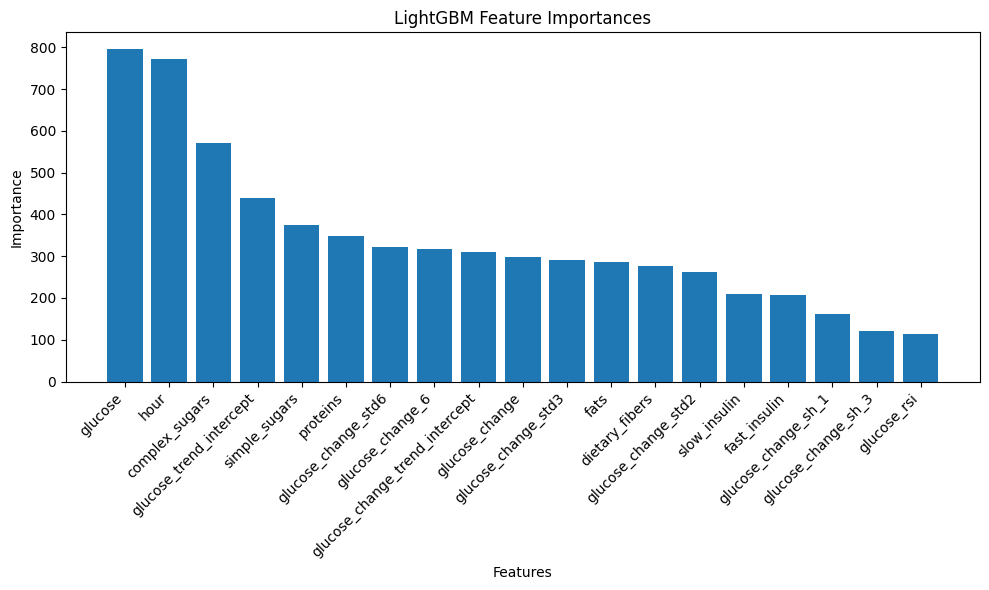

In [147]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
feature_names = X_train.columns
indices = np.argsort(model.feature_importances_)[::-1]
sorted_importances = model.feature_importances_[indices]
sorted_features = feature_names[indices]
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=45, ha='right')
plt.title('LightGBM Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [14]:
train

,glucose,datetime,hour,glucose_next,glucose_change,glucose_change_6,glucose_change_sh_1,glucose_change_sh_3,glucose_change_std2,glucose_change_std3,...,glucose_trend_intercept,simple_sugars,complex_sugars,fats,dietary_fibers,proteins,fast_insulin,slow_insulin,patient,day
6,165.76744,2014-10-01 19:39:00,19,30.63094,-3.60364,-19.82002,-3.60364,7.20728,1.624058e-08,0.000000,...,-4.568901e-01,-5.179334,-34.642557,-9.484989,-5.603640,-11.317926,-4.803640,-3.60364,001,1
7,160.36198,2014-10-01 19:44:00,19,25.22548,-5.40546,-18.01820,-3.60364,-3.60364,1.274079e+00,1.040281,...,3.314062e+00,-6.356154,-27.244377,-11.405460,-7.405460,-13.119746,-5.105460,-5.40546,001,1
8,156.75834,2014-10-01 19:49:00,19,19.82002,-3.60364,-12.61274,-5.40546,-3.60364,1.274079e+00,1.040281,...,-3.371977e+00,-3.929334,-16.242557,-9.603640,-5.603640,-11.317926,-1.803640,-3.60364,001,1
9,151.35288,2014-10-01 19:54:00,19,10.81092,-5.40546,-25.22548,-3.60364,-3.60364,1.274079e+00,1.040281,...,-3.519984e+00,-5.106154,-8.844377,-11.405460,-7.405460,-13.119746,-2.105460,-5.40546,001,1
10,147.74924,2014-10-01 19:59:00,19,3.60364,-3.60364,-25.22548,-5.40546,-5.40546,1.274079e+00,1.040281,...,-4.427329e+00,-2.718779,2.039110,-9.603640,-5.603640,-11.317926,0.996360,-3.60364,001,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,79.28008,2014-10-03 23:31:56,23,-12.61274,0.00000,7.20728,1.80182,0.00000,1.274079e+00,1.040281,...,1.293449e+00,0.000000,9.000000,1.345304,-0.002986,-0.384214,-0.817778,0.00000,008,3
1060,79.28008,2014-10-03 23:36:56,23,-14.41456,0.00000,5.40546,0.00000,1.80182,0.000000e+00,1.040281,...,1.518677e+00,0.000000,9.000000,1.373280,0.102252,-0.262786,-0.703333,0.00000,008,3
1061,79.28008,2014-10-03 23:41:56,23,-16.21638,0.00000,3.60364,0.00000,1.80182,0.000000e+00,0.000000,...,2.117139e+00,0.000000,8.902500,1.401256,0.207490,-0.141357,-0.453333,0.00000,008,3
1062,79.28008,2014-10-03 23:46:56,23,-18.01820,0.00000,3.60364,0.00000,0.00000,0.000000e+00,0.000000,...,1.061787e+00,0.000000,8.152500,1.429232,0.312729,-0.019929,-0.203333,0.00000,008,3
